In [18]:
import pandas as pd
import numpy as np
import pickle
import sys

import sklearn.model_selection
import sklearn.pipeline

sys.path.append("/home/icb/sergey.vilov/workspace/MLM/mpra/utils")

from mlp import *
from misc import dotdict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data_dir='/lustre/groups/epigenereg01/workspace/projects/vale/mlm/mpra/siegel_2022/'

In [26]:
input_params = dotdict({})

input_params.mpra_tsv = data_dir + 'Beas2B.tsv'
input_params.response = 'stability'
input_params.model = 'DNABERT'
input_params.embeddings = data_dir + 'embeddings/dnabert-3utr/predictions.pickle'

In [27]:
mpra_df = pd.read_csv(input_params.mpra_tsv, sep='\t') #sequence info

#Data Cleaning
# Take only SNP mutations
# Remove nan values in Expression column

if input_params.response == 'steady_state':
    mpra_df['Expression'] = mpra_df.ratios_T0_GC_resid
elif input_params.response == 'stability':
    mpra_df['Expression'] = mpra_df.ratios_T4T0_GC_resid

#flt = (mpra_df.Expression.isna()) | (mpra_df.ARE_length_perfect.isna()) | (mpra_df.stop_codon_dist.isna()) | (mpra_df.stop_codon_dist>5000) | (~mpra_df.issnp.astype(bool))

flt = (mpra_df.Expression.isna()) | (mpra_df.stop_codon_dist.isna()) | (~mpra_df.issnp.astype(bool))

mpra_df = mpra_df[~flt]

mpra_df['group'] = mpra_df.region.apply(lambda x:x.split('|')[1].split(':')[0])

if input_params.embeddings!=None:
    with open(input_params.embeddings,'rb') as f:

        X = pickle.load(f)
        print(f'number of sequences after filtering: {len(mpra_df)}')
        print(f"embeddings size: {len(X['embeddings'])}")
        seq_indices=[int(seq_name.replace('id_','')) for seq_name in X['seq_names']]
        mpra_df = mpra_df[mpra_df.index.isin(seq_indices)]
        embeddings = {seq_name:emb for seq_name,emb in zip(X['seq_names'], X['embeddings'])}
        X = [embeddings[f'id_{seq_idx}'] for seq_idx in mpra_df.index]
        X = np.array(X)
        print(f'number of sequences overlapping with embeddings: {len(X)}')
        #X = X[mpra_df.index]

y = mpra_df['Expression'].values
groups = mpra_df['group'].values

number of sequences after filtering: 4169
embeddings size: 49836
number of sequences overlapping with embeddings: 4169


In [28]:
gss = sklearn.model_selection.LeaveOneGroupOut()

train_idx, test_idx = next(iter(gss.split(X, y, groups)))

X_train, y_train, X_test, y_test = X[train_idx],y[train_idx], X[test_idx],y[test_idx]

In [77]:
M=MLPRegressor(hidden_layer_sizes=(128, 32, 16,), 
                 p_dropout=0., weight_decay=5e-5, lr=1e-4,
                batch_size = 1024, N_epochs = 300)

In [ ]:
all_scores = []
for seed in range(10):

    scores = []
    
    for train_idx, test_idx in gss.split(X, y, groups):
    
        X_train, y_train, X_test, y_test = X[train_idx],y[train_idx], X[test_idx],y[test_idx]
    
        M.fit(X_train, y_train, X_test, y_test)
    
        y_pred = M.predict(X_test)
    
        score = pearson_r(y_test,y_pred)
    
        scores.append(score)
    
    print(np.mean(scores))

    all_scores.append(np.mean(scores))

print(np.mean(all_scores),np.std(all_scores))

In [69]:
print(np.mean(scores))

0.4803554570002486


In [ ]:
#%%timeit -n 1 -r 1
M.fit(X_train, y_train, X_test, y_test)

In [38]:
y_pred = M.predict(X_test)
sklearn.metrics.r2_score(y_test,y_pred)

0.3068262853314013

In [42]:
M.score(X_test,y_test)

0.56355596

In [41]:
t,v=zip(*M.history_)

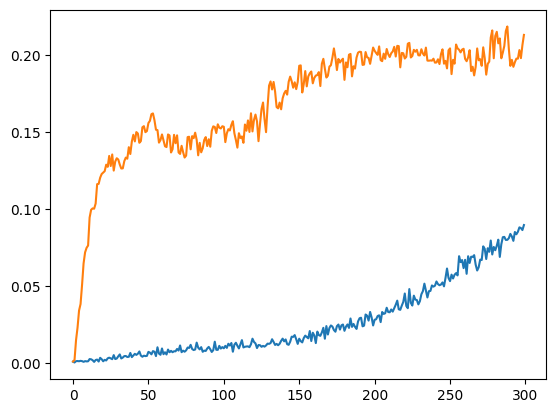

In [42]:
import matplotlib.pyplot as plt

plt.plot(t)
plt.plot(v)

In [113]:
def hpp_search_mlp(X,y,groups,forced_hpp={},cv_splits = 5):

    #X, y = prepare_train_data(X,y)

    param_distributions = {
            'MLP__p_dropout':[0,],
            'MLP__weight_decay':[5e-5,],
            'MLP__hidden_layer_sizes':[(128,32,16),],
        }

    pipe = sklearn.pipeline.Pipeline(steps=[
         ('MLP', MLPRegressor())
        ])

    pipe.set_params(**forced_hpp)

    clf = sklearn.model_selection.RandomizedSearchCV(pipe, param_distributions, scoring = None,
                    cv = sklearn.model_selection.LeaveOneGroupOut(),  n_jobs = 1, n_iter=10, random_state=1, verbose=10)

    search = clf.fit(X, y, groups=groups)

    return search.best_score_

In [ ]:
hpp_dict = {'MLP__N_epochs':300,'MLP__lr':1e-4,'MLP__batch_size':1024} #pre-determined hpp, to reduce search time
best_hpp = hpp_search_mlp(X,y,groups,forced_hpp=hpp_dict,cv_splits = 5) #get optimal hyperparameters

In [123]:
best_hpp

0.4807068109512329

{'ll': 3, 'ee': 4}

In [121]:
import re



'll'